<a href="https://colab.research.google.com/github/morenourey/CHAT/blob/main/ML_2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUP ML 2 - MODEL

# Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import graphviz

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")


In [34]:
# preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
# algoritmos de clasificación
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# algoritmos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
# metricas
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Carga clean data

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
df_train = pd.read_pickle("final_df.pkl")

# Split X-y

In [5]:
target = 'churn'

In [6]:
# En clasificación, el target es booleano (True/False)
df_train[target] = df_train[target].astype('bool')

In [7]:
features = [i for i in df_train.columns if i != target]

In [8]:
features

['rev',
 'mou',
 'totmrc',
 'da',
 'ovrmou',
 'ovrrev',
 'vceovr',
 'datovr',
 'roam',
 'change_mou',
 'change_rev',
 'drop_vce',
 'drop_dat',
 'blck_vce',
 'blck_dat',
 'unan_vce',
 'unan_dat',
 'plcd_vce',
 'plcd_dat',
 'recv_vce',
 'recv_sms',
 'comp_vce',
 'comp_dat',
 'custcare',
 'ccrndmou',
 'cc_mou',
 'inonemin',
 'threeway',
 'mou_cvce',
 'mou_cdat',
 'mou_rvce',
 'owylis_vce',
 'mouowylisv',
 'iwylis_vce',
 'mouiwylisv',
 'peak_vce',
 'peak_dat',
 'mou_peav',
 'mou_pead',
 'opk_vce',
 'opk_dat',
 'mou_opkv',
 'mou_opkd',
 'drop_blk',
 'attempt',
 'complete',
 'callfwdv',
 'callwait',
 'months',
 'uniqsubs',
 'actvsubs',
 'totcalls',
 'totmou',
 'totrev',
 'adjrev',
 'adjmou',
 'adjqty',
 'avgrev',
 'avgmou',
 'avgqty',
 'avg3mou',
 'avg3qty',
 'avg3rev',
 'avg6mou',
 'avg6qty',
 'avg6rev',
 'hnd_price',
 'phones',
 'models',
 'truck',
 'rv',
 'lor',
 'adults',
 'income',
 'numbcars',
 'forgntvl',
 'eqpdays',
 'new_cell_N',
 'new_cell_U',
 'new_cell_Y',
 'crclscod_A',
 'crclsc

In [9]:
y = df_train[target]
X = df_train[features]

# Distribución del target

In [10]:
# Distribucion en %
y.value_counts(normalize=True)


churn
False    0.500763
True     0.499237
Name: proportion, dtype: float64

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

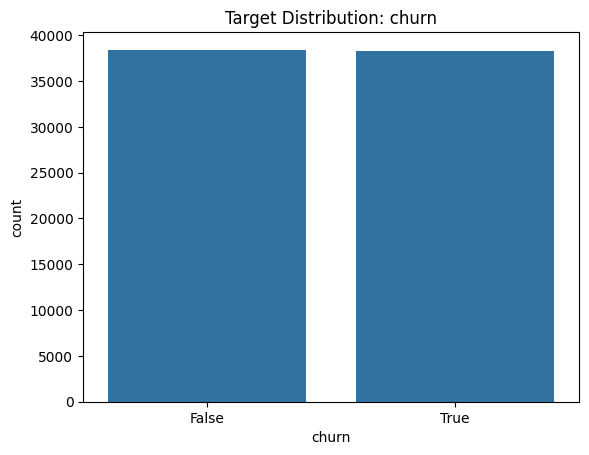

In [11]:
sns.countplot(x=y)
plt.title('Target Distribution: '+target) #Notamos que la target está balanceada
plt.show()

# Split TRAIN-TEST

In [12]:
# se guarda un 30% de datos para el test y un 70% para el train
y = df_train['churn']
X = df_train.drop('churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [13]:
# Hemos realizado ya el rescaling mediante la técnica de MinMaxScaler en ML 1 - Preprocessing, por lo tanto no es necesario hacer rescaling en ML 2 - Model

# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

In [14]:
def medicion(y_t, y_p):
  """imprime la curva ROC y el AUC"""
  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)
  # para añadir el gráfico
  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [28]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""
  # creamos la lista de auc vacía
  lista_aucs = []
  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)
  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))
  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)
  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))
  # RidgeClassifier
  print('RidgeClassifier')
  rc = RidgeClassifier(max_iter=40)
  rc.fit(Xtrain, ytrain)
  y_pred = rc.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('RidgeClassifier', round(roc_auc, 5)))
  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)
  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))
  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)
  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))
  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)
  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))
  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = XGBClassifier(random_state=42)
  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))
  # CatBoostClassifier
  print('CatBoostClassifier')
  cat_base = CatBoostClassifier(verbose=False, random_state=42)
  cat_base.fit(Xtrain, ytrain)
  y_pred = cat_base.predict(Xtest)
  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('CatBoost Classifier', round(roc_auc, 5)))
  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')
  return df_aucs

Support Vector Machine


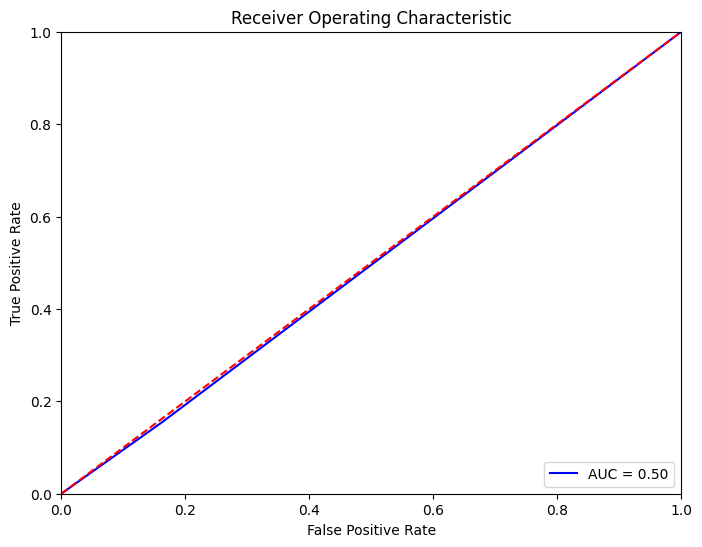

Regresión logística


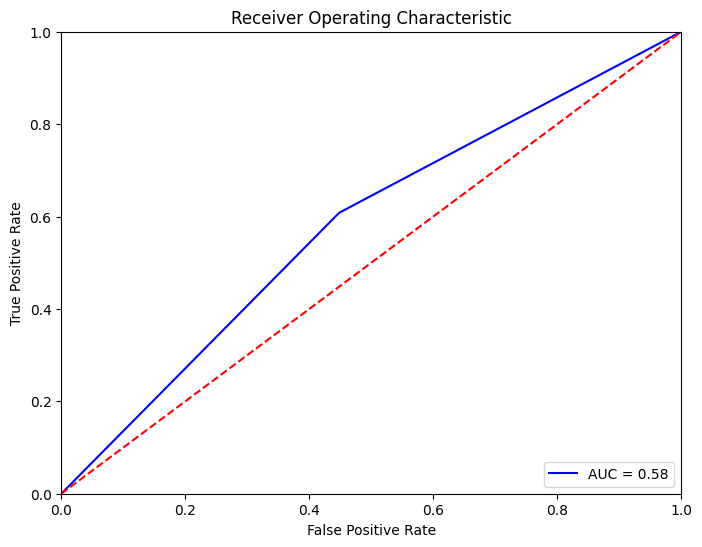

RidgeClassifier


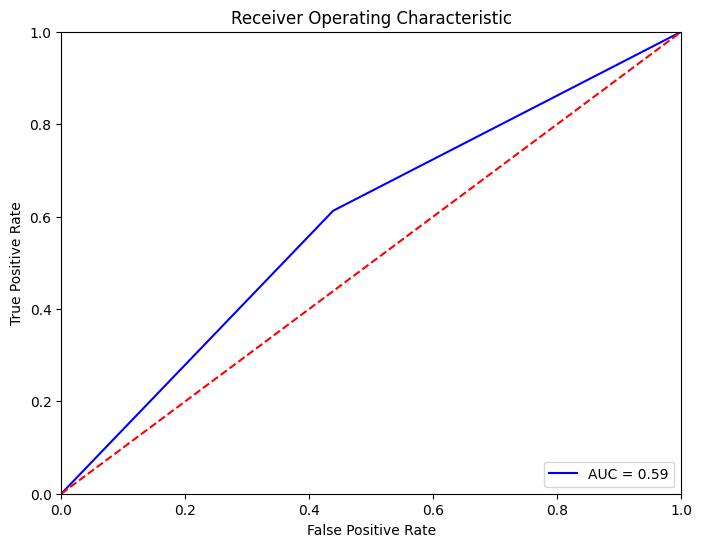

Decision tree classsifier


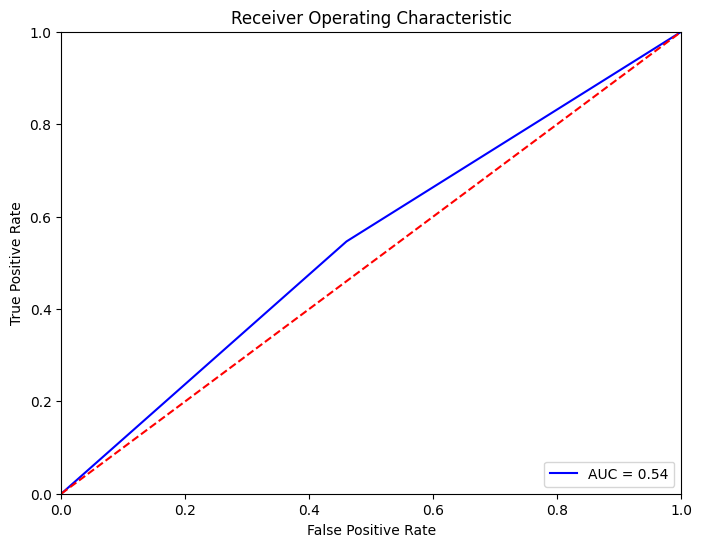

Random forest


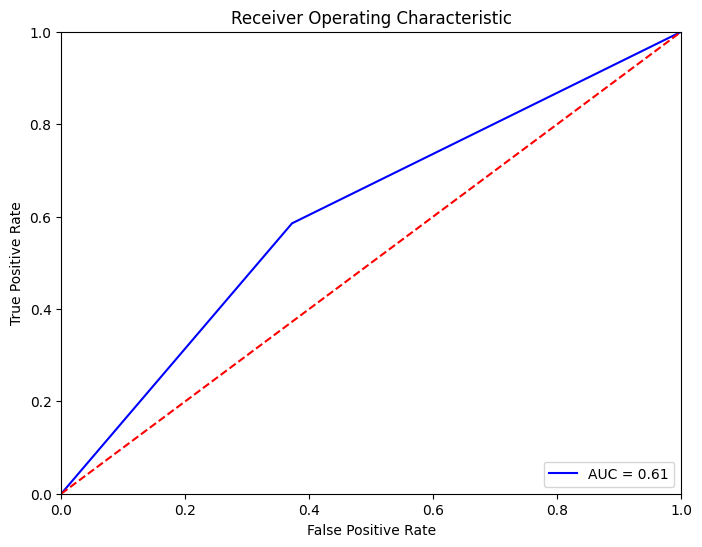

Gradient boosting


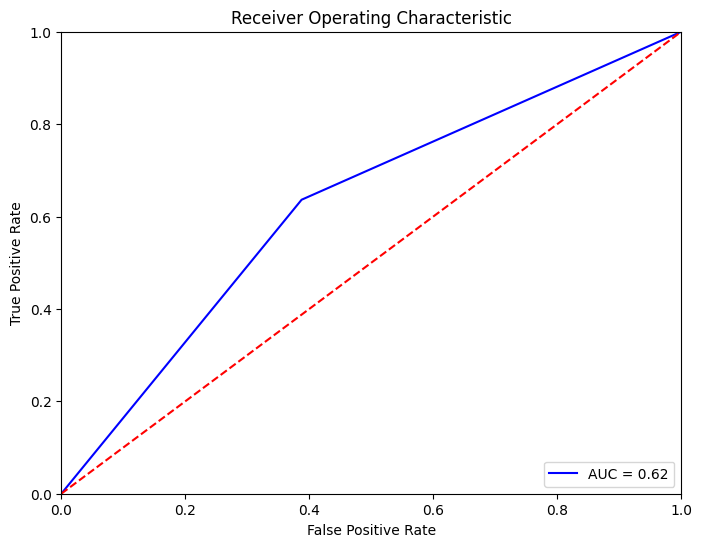

XGBClassifier


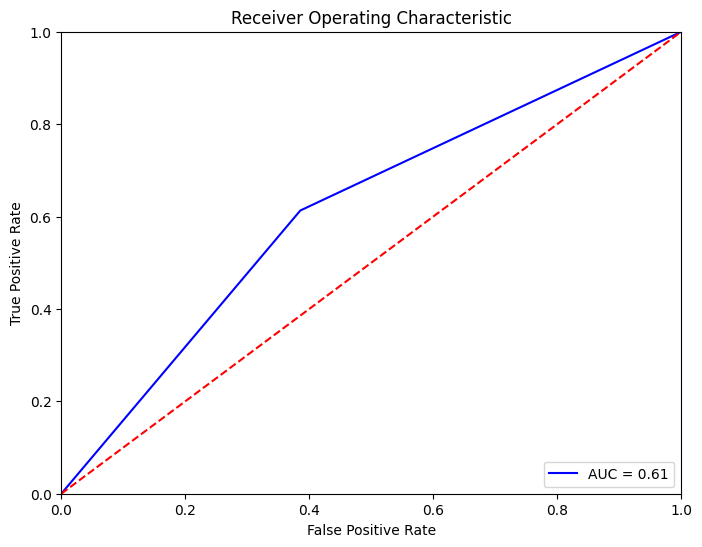

CatBoostClassifier


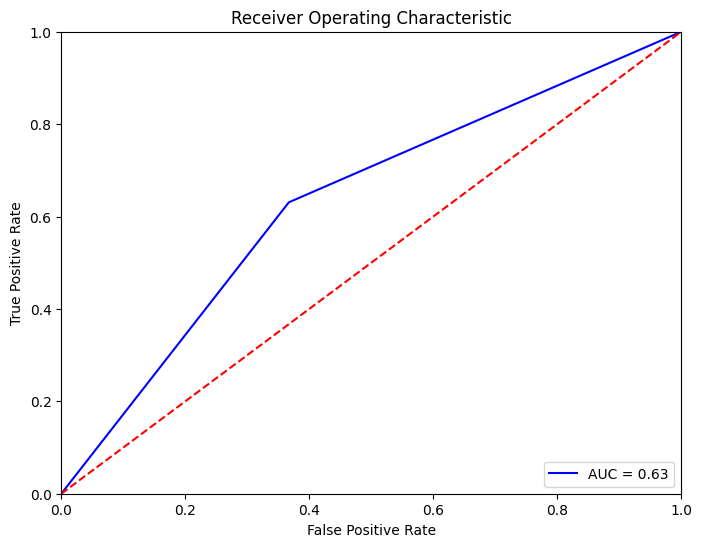

In [29]:
aucs = entrenar(X_train, X_test, y_train, y_test)

In [34]:
aucs.sort_values(by='AUC')

,AUC
modelos,
SVC,0.49611
decision tree classifier,0.54301
regresión logística,0.57996
RidgeClassifier,0.58699
random forest,0.60654
XGB classifier,0.61374
gradient boosting,0.62437
CatBoost Classifier,0.63185


In [40]:
# Lista de modelos
modelos = [
    ('RF', RandomForestClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('NB', GaussianNB()),
    ('CatBoostClassifier', CatBoostClassifier(verbose=False)),
    ('DecisionTreeClassifier', DecisionTreeClassifier())]

metricas = pd.DataFrame({'modelo':[], 'f1_score':[]})

for nombre, modelo in modelos:
  # entrenamiento
  modelo.fit(X_train, y_train)

  y_pred = modelo.predict(X_test)

  # evalua la metrica
  f1_score = metrics.f1_score(y_test, y_pred, average='macro')

  # añade la métrica al dataframe de métricas
  metricas = metricas._append({'modelo':nombre, 'f1_score':f1_score}, ignore_index = True)

  print(nombre, np.round(f1_score,5))

RF 0.60598
LR 0.58344
KNN 0.51123
NB 0.52077
CatBoostClassifier 0.63172
DecisionTreeClassifier 0.54239


In [42]:
metricas.sort_values(by='f1_score', ascending = False)

,modelo,f1_score
4,CatBoostClassifier,0.631724
0,RF,0.605982
1,LR,0.583440
5,DecisionTreeClassifier,0.542389
3,NB,0.520775
2,KNN,0.511229


## Hiperparametrizacion

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

In [49]:
# Opciones de búsqueda de los parámetros
param_dist = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'scale_pos_weight': [1, 2, 3]
}

In [50]:
""" model = CatBoostClassifier(
    iterations=1000,  # Número de iteraciones
    learning_rate=0.1,  # Tasa de aprendizaje
    depth=6,  # Profundidad de los árboles
    loss_function='Logloss',  # Función de pérdida
    eval_metric='Accuracy',  # Métrica de evaluación
    random_seed=42,  # Semilla aleatoria para reproducibilidad
    verbose=100  # Mostrar logs cada 100 iteraciones
) """

# Crear el modelo CatBoostClassifier
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

In [54]:
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    scoring='accuracy',
    cv=3,  # Validación cruzada con 3 particiones
    random_state=42,
    verbose=1,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.5845160	total: 9.16ms	remaining: 9.15s
100:	learn: 0.6278169	total: 878ms	remaining: 7.81s
200:	learn: 0.6442433	total: 1.79s	remaining: 7.1s
300:	learn: 0.6586769	total: 2.65s	remaining: 6.16s
400:	learn: 0.6718069	total: 3.42s	remaining: 5.12s
500:	learn: 0.6828882	total: 4.2s	remaining: 4.18s
600:	learn: 0.6940813	total: 4.94s	remaining: 3.28s
700:	learn: 0.7040451	total: 5.66s	remaining: 2.42s
800:	learn: 0.7146050	total: 6.4s	remaining: 1.59s
900:	learn: 0.7233955	total: 7.12s	remaining: 783ms
999:	learn: 0.7323351	total: 7.84s	remaining: 0us


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001E3000FAFF0>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [500, 1000, 1500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'scale_pos_weight': [1, 2, 3]},
                   random_state=42, scoring='accuracy', verbose=1)

In [55]:
# Obtener los mejores hiperparámetros
best_params = random_search.best_params_
print(f'Mejores hiperparámetros: {best_params}')

Mejores hiperparámetros: {'scale_pos_weight': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 9, 'iterations': 1000, 'depth': 6, 'border_count': 64}


## Modelo final
* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

In [15]:
# Cargar el modelo guardado si existe
try:
    with open('best_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
except FileNotFoundError:
    best_model = None

In [28]:
# Entrenar el mejor modelo
if(not best_model):
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

In [16]:
# Predecir en los datos de prueba
y_pred = best_model.predict(X_test)

# TEST
* Evaluación de las métricas de performance en TEST.

In [17]:
# Evaluar el mejor modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6326424195020206
Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.63      0.63     11571
        True       0.63      0.63      0.63     11442

    accuracy                           0.63     23013
   macro avg       0.63      0.63      0.63     23013
weighted avg       0.63      0.63      0.63     23013

Confusion Matrix:
[[7294 4277]
 [4177 7265]]


# INTERPRETABILITY
* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

In [18]:
# Obtener las características más importantes del modelo CatBoost
feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns

# Crear un DataFrame con las características y sus importancias
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

In [19]:
# Ordenar las características por su importancia
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df.head(5))

       Feature  Importance
48      months   12.952190
76     eqpdays    9.326615
9   change_mou    7.254162
1          mou    6.681261
2       totmrc    4.472450


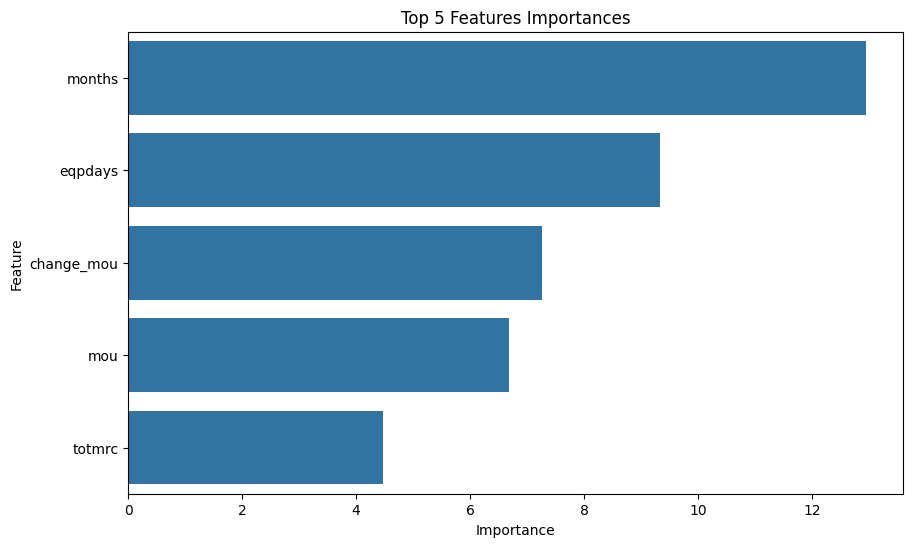

In [20]:
# Graficar las principales características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(5))
plt.title('Top 5 Features Importances')
plt.show()

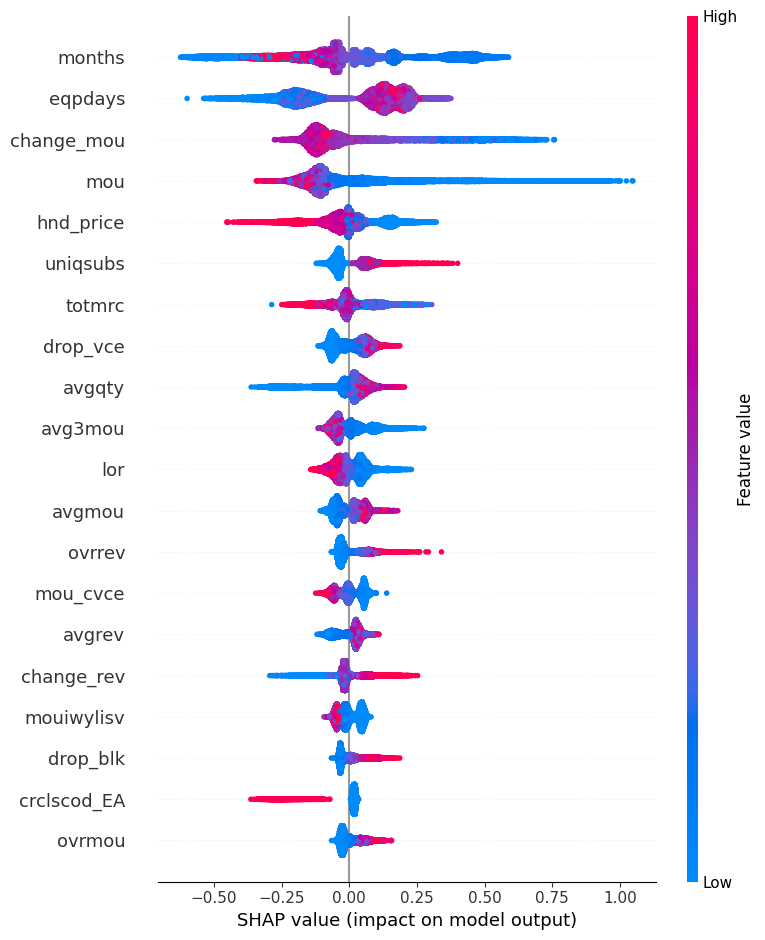

In [21]:
import shap

# Crear un objeto de valores SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Graficar los valores SHAP
#shap.summary_plot(shap_values, X_test, plot_type='bar')
shap.summary_plot(shap_values, X_test)

In [22]:
top5_features = feature_importances_df.head(5)['Feature'].values
top5_features

array(['months', 'eqpdays', 'change_mou', 'mou', 'totmrc'], dtype=object)

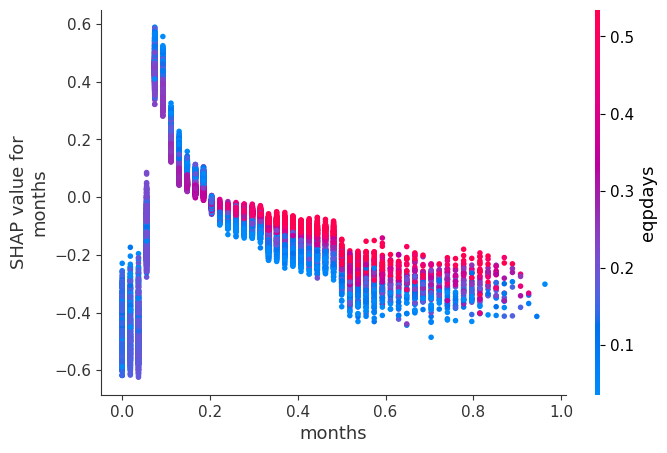

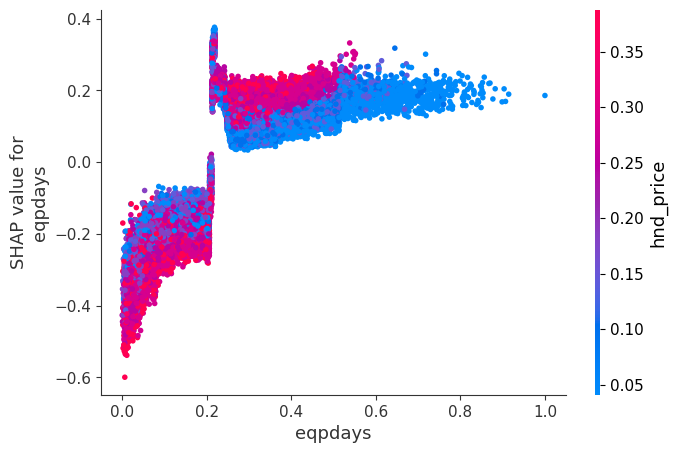

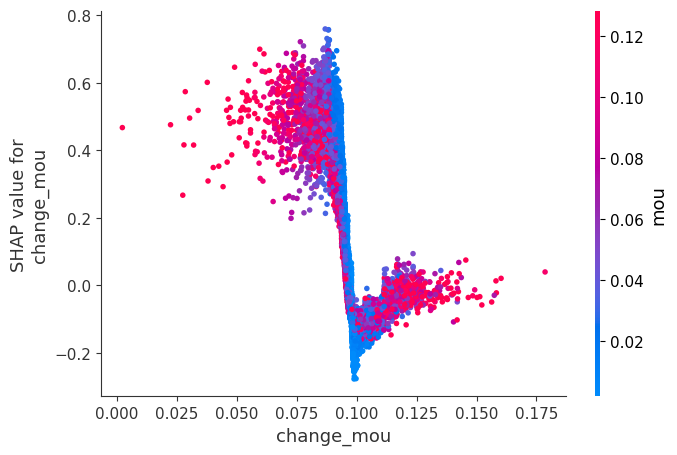

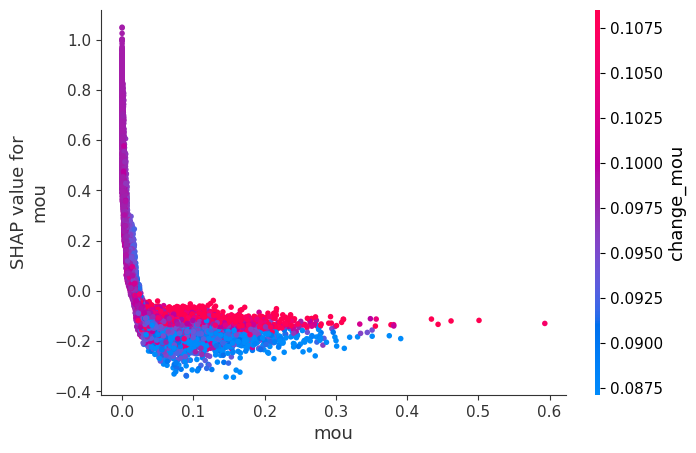

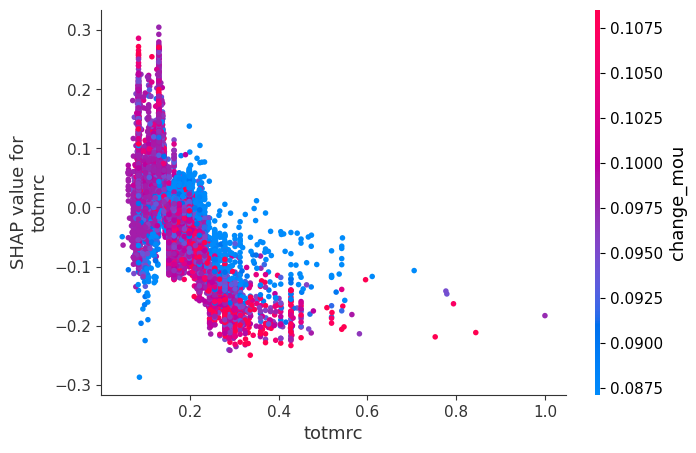

In [23]:
for feature in top5_features:
    shap.dependence_plot(feature, shap_values, X_test)

### Comentarios sobre las 5 características principales

1. **`months`**: 
   - **Impacto**: Los clientes que han estado en el servicio por más meses tienden a tener una menor probabilidad de churn.
   - **Insight**: La retención mejora con la duración del servicio; los clientes a largo plazo están más comprometidos.

2. **`eqpdays`**: 
   - **Impacto**: El número de días que el cliente ha tenido su equipo actual tiene una relación inversa con el churn.
   - **Insight**: Los clientes con equipos más nuevos pueden estar más satisfechos con su experiencia y menos propensos a abandonar el servicio.

3. **`change_mou`**: 
   - **Impacto**: Un cambio significativo en los minutos de uso mensual en comparación con el promedio de los tres meses anteriores puede indicar un aumento en la insatisfacción o un cambio en el comportamiento del cliente.
   - **Insight**: Monitorear cambios abruptos en el uso puede ayudar a identificar clientes en riesgo de churn.

4. **`mou`**: 
   - **Impacto**: El número promedio de minutos de uso mensual muestra una relación directa con la retención; mayor uso está asociado con menor churn.
   - **Insight**: Fomentar el uso del servicio puede contribuir a la retención de clientes.

5. **`totmrc`**: 
   - **Impacto**: El cargo mensual recurrente total también influye en la retención; cargos más altos pueden estar relacionados con servicios adicionales que mantienen a los clientes satisfechos.
   - **Insight**: Clientes que pagan más por servicios adicionales pueden estar más satisfechos y menos propensos a cambiar de proveedor.

### Análisis complementarios

#### Modelos de árboles: plot de árbol de decisión

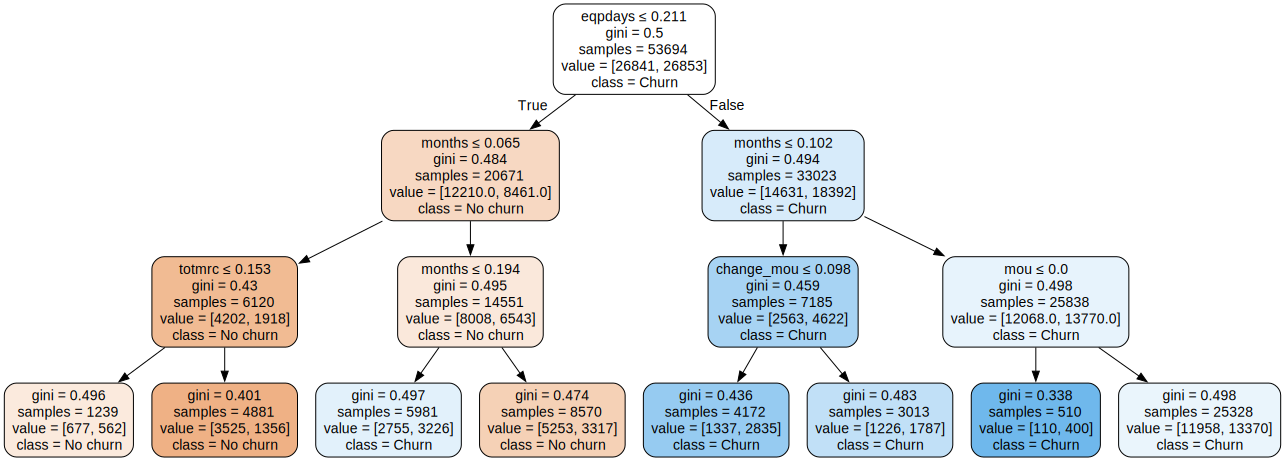

In [32]:
# Entrenar un árbol de decisión simple en las mismas características
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train[top5_features], y_train)
dot_data = tree.export_graphviz(dt_model, out_file=None, 
                                feature_names=top5_features,  
                                class_names=['No churn', 'Churn'],  
                                filled=True, rounded=True,  
                                special_characters=True) 
# Visualizar el árbol de decisión
graphviz.Source(dot_data)

#### Modelos lineales: Coeficientes y fórmula del modelo

In [35]:
# Para los modelos lineales, como una regresión logística, obtendremos los coeficientes y formularemos el modelo:
from sklearn.linear_model import LogisticRegression

# Ajustar un modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Obtener los coeficientes del modelo y features
coefficients = log_reg.coef_[0]
features = X_train.columns

# Array de coeficientes y features, y ordenar por la magnitud de los coeficientes
coef_feature_pairs = sorted(zip(np.abs(coefficients), coefficients, features), reverse=True)

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(coef_df.head(10))

     Feature  Coefficient
58    avgmou     3.327230
6     vceovr     2.297478
5     ovrrev     1.968737
49  uniqsubs     1.808970
76   eqpdays     1.649224
59    avgqty     1.601833
68    models     1.339577
11  drop_vce     1.291534
4     ovrmou     1.255967
0        rev     1.197173


In [36]:
# Fórmula del modelo ordenada por la importancia de las características
formula = ' + '.join([f'{coef:+.2f} * {feat}' for _, coef, feat in coef_feature_pairs])
print('Model Formula:')
print(f'churn = {log_reg.intercept_[0]:.2f} + {formula}')

Model Formula:
churn = 0.16 + -4.26 * mou + +3.33 * avgmou + -2.88 * change_mou + +2.30 * vceovr + -2.08 * avg3mou + +1.97 * ovrrev + -1.95 * threeway + +1.81 * uniqsubs + +1.65 * eqpdays + -1.60 * iwylis_vce + +1.60 * avgqty + -1.38 * adjrev + +1.34 * models + +1.29 * drop_vce + +1.26 * ovrmou + -1.22 * totmrc + +1.20 * rev + +1.11 * change_rev + -1.09 * months + +1.08 * avgrev + -1.03 * avg3qty + -0.97 * totrev + +0.95 * drop_blk + +0.93 * totmou + +0.92 * phones + +0.87 * roam + -0.87 * hnd_price + -0.79 * opk_vce + -0.77 * peak_vce + -0.75 * ccrndmou + +0.74 * avg6qty + +0.72 * adjmou + -0.69 * mou_peav + -0.68 * cc_mou + -0.64 * mou_cvce + -0.60 * callwait + +0.59 * da + +0.53 * avg6rev + -0.49 * recv_vce + +0.47 * actvsubs + +0.43 * mou_opkv + +0.43 * mou_rvce + +0.39 * blck_vce + -0.36 * adjqty + +0.34 * ethnic_O + -0.32 * ethnic_Z + -0.32 * crclscod_EA + +0.30 * recv_sms + +0.29 * plcd_vce + +0.29 * attempt + +0.28 * datovr + +0.25 * area_NORTHWEST/ROCKY MOUNTAIN AREA + +0.23 *

### Guardar los resultados

In [100]:
# Guardar el modelo entrenado
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)